The primary objective of this competition is to employ deep learning-based regression models, such as Convolutional Neural Networks (CNNs) like ConvNext or Transformers, to predict plant traits from photographs. These plant traits, although available for each image, may not yield exceptionally high accuracies due to the inherent heterogeneity of citizen science data. The various plant traits describe chemical tissue properties that are loosely related to the visible appearance of plants in images. Despite the anticipated moderate accuracies, the overarching goal is to explore the potential of this approach and gain insights into global changes affecting ecosystems. Your contribution to uncovering the wealth of data and the distribution of plant traits worldwide is invaluable.

Our goal is to predict a broad set of 6 plant traits (e.g. leaf area, plant height) from crowd-sourced plant images and some ancillary data. 

The models will be evaluated against the independent test data. The evaluation metric for this competition is the mean R2 over all 6 traits. The R2 is commonly used for evaluating regression models and is the ratio of the sum of squares the residuals (SSres) to the total sum of squares (SStot).

The R2 can result in large negative values. To prevent that we will only consider R2 values > 0.

The submission should include a .csv file with a prediction for each trait and the following columns: id (see labels) and a prediction for each trait (X1080, X50, …). An example is given with sample_submission.csv


In [1]:
#imports and variables
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

DATA_DIR = os.getcwd() +'/data/' #data directory kaggle: /kaggle/input/planttraits2024/

In [2]:
class CONFIG:
    sub = f"{DATA_DIR}sample_submission.csv"
    trgts = f"{DATA_DIR}target_name_meta.tsv"
    train_path = f"{DATA_DIR}train.csv"
    test_path = f"{DATA_DIR}test.csv"
    train_image_path = f"{DATA_DIR}train_images/"
    test_image_path = f"{DATA_DIR}test_images/"
    SEED = 42 #seed for reproducibility
    IMAGE_SIZE = [224, 224] 
    BATCH_SIZE = 64
    EPOCHS = 8
    CLASS_NAMES  =['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean'] #target columns in dataset to predict

    aux_class_names = list(map(lambda x: x.replace("mean","sd"), CLASS_NAMES))
    num_classes = len(CLASS_NAMES)
    aux_num_classes = len(aux_class_names)

config = CONFIG()
len(CONFIG.CLASS_NAMES)

6

In [3]:
#load train.csv and test.csv as pandas dataframe
train = pd.read_csv(config.train_path)
test = pd.read_csv(config.test_path)

In [4]:
#add image path to the dataframe
train['image_path'] = f'{DATA_DIR}/train_images/' + train['id'].astype(str) + '.jpeg'
test['image_path'] = f'{DATA_DIR}/test_images/' + test['id'].astype(str) + '.jpeg'

# drop missing values in the target columns
train = train.drop_duplicates(subset=['id']).dropna(subset=CONFIG.CLASS_NAMES)
display(train.head(2))

FEATURE_COLS = test.columns[1:-1].tolist()


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,/home/btg/Documents/GitHub-khlee/CS5242_plantT...
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,/home/btg/Documents/GitHub-khlee/CS5242_plantT...


In [5]:
#this is just to check if everything is working fine
train.loc[train['id'] == 100010249, config.CLASS_NAMES]

,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
24553,0.47654,11.378406,6.366832,45.152675,1.910018,3937.028466


In [6]:
#split the train data into train and validation set
from sklearn.model_selection import train_test_split

#use only target columns for training, and image_path
train = train[['id', 'image_path'] + config.CLASS_NAMES]
#use 80/20 split
train_df, val_df = train_test_split(train, test_size=0.2, random_state=config.SEED)

print(f"Train shape: {train_df.shape}, Validation shape: {val_df.shape}")

Train shape: (44391, 8), Validation shape: (11098, 8)


In [7]:
#setup dataloaders

class PlantDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]).convert('RGB')
        target = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, target
    
#setup data augmentation
train_transforms = transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE),
    # transforms.RandomResizedCrop(config.IMAGE_SIZE[0]),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE),
    # transforms.RandomResizedCrop(config.IMAGE_SIZE[0]),
    transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#setup dataloaders
train_dataset = PlantDataset(paths= train_df['image_path'].tolist(), labels= train_df[config.CLASS_NAMES].values, transform=train_transforms)
val_dataset = PlantDataset(paths= val_df['image_path'].tolist(), labels= val_df[config.CLASS_NAMES].values, transform=val_transforms)
# train_dataset = PlantDataset(paths= , labels= train_df[config.CLASS_NAMES].values, transform=train_transforms)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

#create params for configuration
dataset_sizes = len(train_df), len(val_df)
total_epochs = config.EPOCHS
batch_size = config.BATCH_SIZE
total_train_steps = dataset_sizes[0] * total_epochs * batch_size
warmup_steps =  total_train_steps//10
decay_steps = total_train_steps - warmup_steps

display(f"data sizes: {dataset_sizes}, total epochs: {total_epochs}, batch size: {batch_size}, total train steps: {total_train_steps}, warmup steps: {warmup_steps}, decay steps: {decay_steps}")


'data sizes: (44391, 11098), total epochs: 8, batch size: 64, total train steps: 22728192, warmup steps: 2272819, decay steps: 20455373'

In [8]:
#define Dataset class
class PlantTabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def get_input_dimensions(self):
        return self.X.size(1)
    
    def get_output_dimensions(self):
        return self.y.size(1)

In [10]:
train_loader.dataset[random.randint(0,dataset_sizes[0])]

(tensor([[[-1.5699, -1.5185, -1.3302,  ..., -1.7583, -1.7754, -1.7754],
          [-1.6042, -1.5357, -1.3644,  ..., -1.7412, -1.7583, -1.7583],
          [-1.6898, -1.6384, -1.4843,  ..., -1.7240, -1.7069, -1.7069],
          ...,
          [-0.9363, -0.9877, -1.1418,  ...,  1.6324,  1.5810,  1.5639],
          [-1.0219, -1.0733, -1.1760,  ...,  1.6153,  1.5639,  1.5468],
          [-1.1418, -1.1589, -1.2274,  ...,  1.6153,  1.5468,  1.5297]],
 
         [[-1.6856, -1.6331, -1.4405,  ..., -1.6856, -1.7031, -1.7031],
          [-1.6856, -1.6155, -1.4405,  ..., -1.6681, -1.6856, -1.6856],
          [-1.6506, -1.5980, -1.4230,  ..., -1.6681, -1.6331, -1.6331],
          ...,
          [-0.9153, -0.9853, -1.1078,  ...,  0.9055,  0.8704,  0.8354],
          [-0.9328, -0.9503, -1.0553,  ...,  0.8529,  0.8004,  0.8004],
          [-0.9678, -0.9853, -1.0553,  ...,  0.8529,  0.7829,  0.7479]],
 
         [[-1.6999, -1.6650, -1.5256,  ..., -1.5953, -1.6302, -1.6476],
          [-1.6999, -1.6650,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


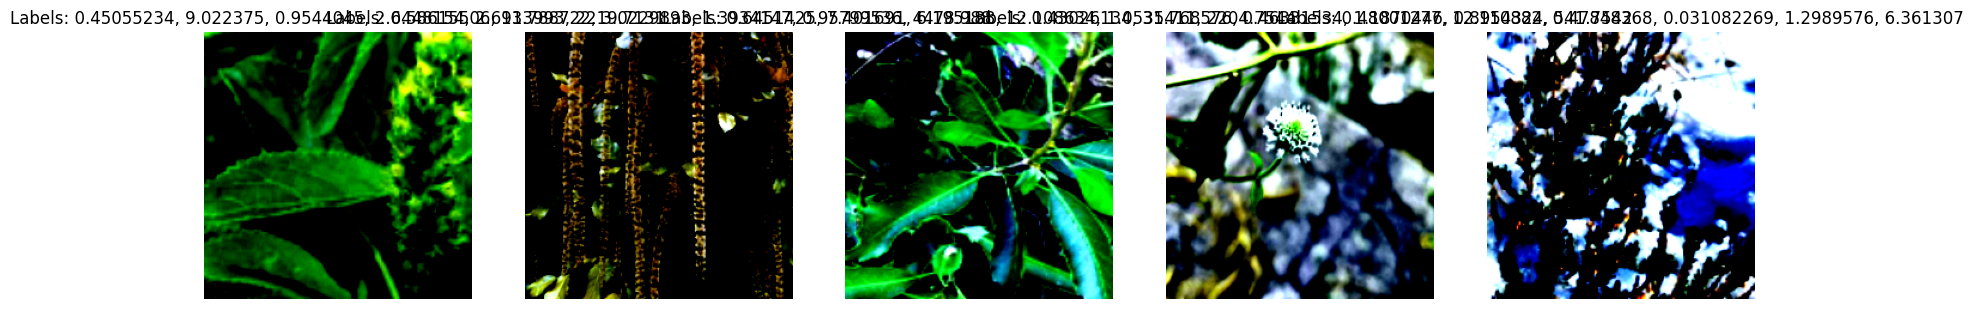

In [11]:


def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 10))
    for idx, (image, label) in enumerate(zip(images, labels)):
        image = image.permute(1, 2, 0)  
        axes[idx].imshow(image)
        label_str = ", ".join([str(val) for val in label])  
        axes[idx].set_title(f"Labels: {label_str}")
        axes[idx].axis("off")
    plt.show()

num_images_to_display = 5
sample_indices = torch.randint(len(train_dataset), size=(num_images_to_display,))
sample_images = [train_dataset[i][0] for i in sample_indices]
sample_labels = [train_dataset[i][1] for i in sample_indices]

sample_labels_np = [label.numpy() for label in sample_labels]

show_images(sample_images, sample_labels_np)



In [55]:
#setup model
import torch.nn as nn
import tqdm as notebook_tqdm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PlantModelResNet(nn.Module):
    def __init__(self, num_classes):
        super(PlantModelResNet, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.resnet(x)

class PlantModelCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantModelCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64*56*56, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


#setup NN model
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input = nn.Linear(in_features=input_dim, out_features=64)
        self.hidden_1 = nn.Linear(in_features=64, out_features=64)
        self.hidden_2 = nn.Linear(in_features=64, out_features=16)
        self.hidden_3 = nn.Linear(in_features=16, out_features=16)
        self.hidden_4 = nn.Linear(in_features=16, out_features=10)
        self.output = nn.Linear(in_features=10, out_features=output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.dropout(x)
        x = F.relu(self.hidden_1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden_2(x))
        x = self.dropout(x)
        x = F.relu(self.hidden_3(x))
        x = self.dropout(x)
        x = F.relu(self.hidden_4(x))
        x = self.output(x)
        return x

model = PlantModelResNet(config.num_classes).to(device)
# model = Net(len(FEATURE_COLS), config.num_classes).to(device)

model

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /home/btg/.cache/torch/hub/v0.6.0.zip
/home/btg/miniconda3/envs/cs5242_proj/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/btg/miniconda3/envs/cs5242_proj/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/btg/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████

PlantModelResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [56]:

def train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs, checkpoint_path, best_model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #use mps for mac
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)

    best_loss = float('inf')
    best_model_weights = model.state_dict()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)

        # Training phase
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_dataset)
        print(f"Train Loss: {train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)

            val_loss /= len(val_dataset)
            print(f"Val Loss: {val_loss:.4f}")

        # Save checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }
        torch.save(checkpoint, f"{checkpoint_path}/checkpoint_epoch_{epoch}.pt")

        # Save the best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = model.state_dict()

    # Load the best model weights
    model.load_state_dict(best_model_weights)

    # Save the best model after testing
    torch.save(model.state_dict(), best_model_path)

    # Testing phase
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item() * inputs.size(0)

        test_loss /= len(test_loader.dataset)
        print(f"Test Loss: {test_loss:.4f}")

    return model


In [57]:

#setup optimizer and loss function
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-5)
#loss function for resnet model
criterion = nn.MSELoss()

checkpoint_path = os.getcwd() + '/checkpoints'
best_model_path = os.getcwd() + '/best_model.pt'

model = train_model(model, train_loader, val_loader, val_loader, optimizer, criterion, config.EPOCHS, checkpoint_path, best_model_path)

#load the best model
model.load_state_dict(torch.load(best_model_path))

#save the test results
def save_test_results(model, test_loader, save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #use mps for mac
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_results = []

    with torch.no_grad():
        for inputs, _ in notebook_tqdm.tqdm(test_loader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            test_results.append(outputs.cpu().numpy())

    test_results = np.concatenate(test_results, axis=0)
    np.save(save_path, test_results)

save_path = 'test_results.npy'
save_test_results(model, val_loader, save_path)

#load the test results
test_results = np.load(save_path)
test_results[:5]




Epoch 1/8
----------
Train Loss: 650356189166.8910
Val Loss: 6982408524636352.0000
Epoch 2/8
----------
Train Loss: 650356192601.6224
Val Loss: 6982408524643122.0000
Epoch 3/8
----------


In [62]:
#calculate R2 score
#load best model
model.load_state_dict(torch.load(best_model_path))

# Assuming you have a test dataframe with 'id' column
test  =pd.read_csv(config.test_path)
test["image_path"] = config.test_image_path + test['id'].astype(str) + '.jpeg'
# Drop duplicates
test = test.drop_duplicates()

# Get image paths and labels for the test set
test_paths = test["image_path"].tolist()
class CustomTestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Load and preprocess the image
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return {"image": image}
# Assuming 'transform' is the same transformation you used during training
dataset_test = CustomTestDataset(test_paths, transform=val_transforms)

# Create a data loader for the test set
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [63]:
model.eval()

# Lists to store predictions
all_predictions = []

for inputs in test_dataloader:
    images = inputs["image"].to('cuda')  # Move to the device (e.g., GPU) if available

    # Forward pass
    with torch.no_grad():
        outputs = model(images)

    predictions = outputs.cpu().numpy() if torch.cuda.is_available() else outputs.numpy()

    all_predictions.append(predictions)

# Concatenate predictions from all batches
all_predictions = np.concatenate(all_predictions, axis=0)

In [69]:
# predictions_original_scale = np.expm1(all_predictions)#targets were logged, here we reverse that process
predictions_original_scale = all_predictions
# predictions_original_scale = predictions_original_scale[:5]
predictions_original_scale.shape


(6545, 6)

In [71]:
# sub = pd.read_csv(config.sub)
# Assuming 'predictions_original_scale' is the array of predictions
#convert the predictions to pandas dataframe

sub = pd.DataFrame(predictions_original_scale, columns=['X4', 'X11', 'X18', 'X50', 'X26', 'X3112'])
sub['id'] = test['id'].values
sub = sub[['id', 'X4', 'X11', 'X18', 'X50', 'X26', 'X3112']]

sub.to_csv("submission.csv", index = False)
display(sub)

print(f'shape of submission file: {sub.shape}, num of inf values: {sub.isin([np.inf]).sum().sum()}')

,id,X4,X11,X18,X50,X26,X3112
0,201238668,0.704689,1.907236,1.295185,2.705284,1.962741,3.283386
1,202310319,0.606189,1.585411,-1.247373,2.285404,1.891357,1.362771
2,202604412,0.646265,1.145655,-1.951129,1.763504,1.944037,0.248412
3,201353439,-0.245903,10.073999,7.823420,11.008077,7.533918,40.402538
4,195351745,0.489066,2.496122,-2.256986,3.228780,2.658961,5.871853
...,...,...,...,...,...,...,...
6540,195548469,0.131724,2.480314,12.185890,2.380667,1.577512,-0.253410
6541,199261251,0.617692,1.993944,6.447598,2.407908,1.086040,0.743065
6542,203031744,0.507891,1.823268,-2.597394,2.555762,1.564247,0.928535
6543,197736382,0.464678,1.275444,-0.405115,0.617976,0.928849,0.896099


shape of submission file: (6545, 7), num of inf values: 0
